### Backpropagation using Micrograd

In [260]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [261]:
class Value:

    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data{self.data})"
    
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward

        return out
    
    def tanh(self):
        t = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
        out = Value(t, (self, ), _op = 'tanh')

        def _backward():
            self.grad = (1 - t**2) * out.grad 
        out._backward = _backward

        return out
    
    def backward(self):
        # Use topological sort to reverse the order of nodes
        topo = []
        visited = set()

        def tbuild(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    tbuild(v)
                topo.append(v)

        self.grad = 1
        tbuild(self)

        for node in reversed(topo):
            node._backwards()

In [262]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d*f; L.label = "L"

In [263]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    # Set rankdir to 'LR' (Left to Right) and add it properly in the graph attributes
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Use records for value nodes (rectangular shape with compartments)
        dot.node(name=uid, 
                label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", 
                shape='record')
        
        if n._op:
            op_node_name = uid + n._op
            dot.node(name=op_node_name,
                    label=n._op)
            dot.edge(op_node_name, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

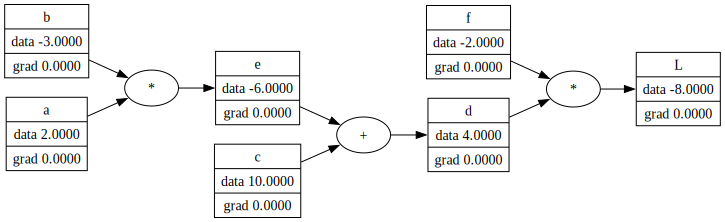

In [264]:
draw_dot(L)

### How to manually find the gradients? 

### Example of how changing values in the direction of the gradient increases value of L

### Backpropagating through a double layer Neuron

We use the activation function, tanh, which is bounded, i.e for inputs higher than a certain number the output plateaus at 1

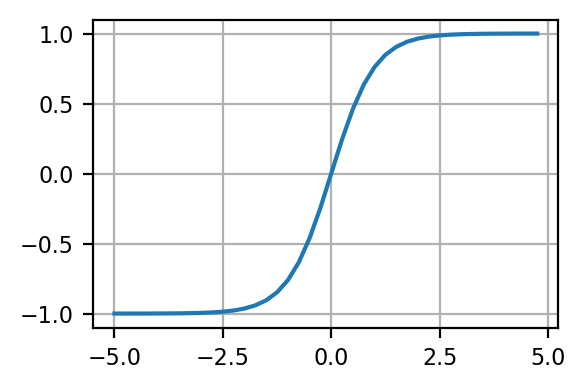

In [265]:
plt.figure(figsize=(3, 2), dpi=200); plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid(); plt.xticks(fontsize=8); plt.yticks(fontsize=8)
plt.show()

In [266]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.88, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

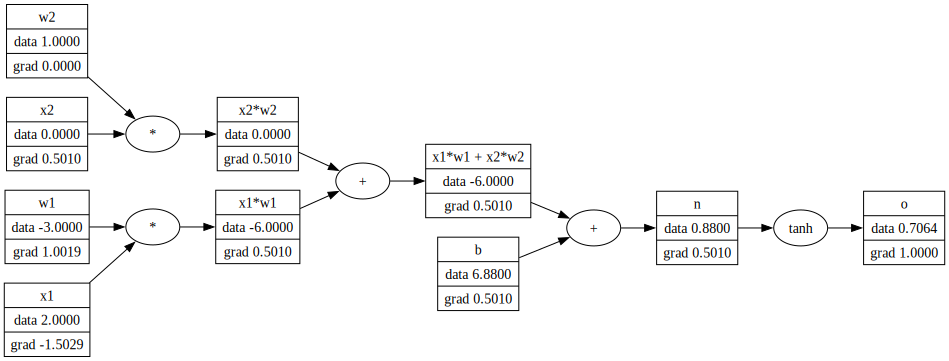

In [267]:
# Manually Implementing BP
# o.grad = 1.0
# n.grad = 1-(o.data)**2
# b.grad = n.grad
# x1w1x2w2.grad = n.grad 
# x2w2.grad, x1w1.grad = x1w1x2w2.grad, x1w1x2w2.grad
# w1.grad = x1w1.grad * x1.data
# x1.grad = x1w1.grad * w1.data
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data

# Instead, call the backward function in right order
o.grad = 1.0 
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
draw_dot(o)

### To make it more autonomous, we can make a backward function that when called on 'o' implements backpropagation

In [271]:
# Use topological sort to reverse the order of nodes
topo_nodes = []
visited = set()

def tbuild(v):
    if v not in visited:
        visited.add(v)
        for child in v.prev:
            tbuild(child)
        topo_nodes.append(v)

o.grad = 1
tbuild(o)

for node in reversed(topo_nodes):
    node._backwards()

[Value(data6.88), Value(data-3.0), Value(data2.0), Value(data-6.0), Value(data0.0), Value(data1.0), Value(data0.0), Value(data-6.0), Value(data0.8799999999999999), Value(data0.7064193203972352)]
